### Python implementation of HBV model
```python
HBV is a simple conceptual hydrological model that simulates the main hydrological processes related to snow, soil, groundwater, and routing. There are many software packages and off-the-shelf products that implement it.

I’ve been experimenting with the model lately and——in an endeavour to better understand the logic behind it——I decided to implement my own version —— in Python, following an intuitive object-oriented programming approach.

This can be flexibly used for different modelling tasks, but can also be used in a classroom setup —— to explain hydrological concepts (processes, calibration, uncertainty analysis, etc.).

This notebook walk the reader through how to use this model. It follows bulding a model and calibrating it and estimating the uncertainity for a case study.

### Getting Started

```python
"""
HBV Hydrological Model

This module integrates the snow, soil, and response routines (routing routine yet to be implemented) into a complete
HBV-like hydrological model. It handles parameter management, data reading, model
execution, calibration, uncertainity and output visualization.

Usage:

    from HBV_model import HBVModel
    model = HBVModel()
    model.load_data("pandas dataframe")
    model.set_parameters(params)
    model.run()
    model.calibrate()
    model.evaluate_uncertainity()
    model.plot_results()
    model.save_results()
    model.save_model("path")
    model.load_model("path")

It is very intiuitive——the model is like an object which has attributes (data, parameters, initial_conditions, etc.) that you can assign and access. The object also performs functions (calibration, uncertainity estimation, save, load, etc.)    

"""

### Import the Required Functions

In [1]:
from HBV_Lab import HBVModel
import pandas as pd
import matplotlib.pyplot as plt 

### Read the Data into a Pandas Dataframe

In [2]:
# Read the dat from excel or csv with pands and save into dataframe
data = pd.read_excel('./data/test_data_2.xlsx') 
data.head(5)

,Date,P,T,Q,PET,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,19810101,0.0,-1.0,0.002,0.05,NaN,NaN,NaN
1,19810102,0.0,-3.6,0.005,0.14,NaN,NaN,HBV_land
2,19810103,0.2,-8.0,0.005,0.46,NaN,NaN,NaN
3,19810104,0.1,-10.3,0.005,1.50,NaN,NaN,NaN
4,19810105,0.0,-15.0,0.005,3.01,NaN,NaN,NaN


### Build an HBV Model
```python 
We will define an HBV model for the calibration period (start_date='1981-01-01', end_date='1983-01-01')
# If you did not define the dates all the data in the DF will be used

In [24]:
# 1. Initialize the model
model_calibration = HBVModel()


# # Read the data from pandas df
model_calibration.load_data(data=data,
               date_column='Datee',
               precip_column='P',
               temp_column='T',
               pet_column='PET',
               obs_q_column='Q',
               date_format='%Y%m%d',
               start_date=None,
               warmup_end= '19820101',          
               end_date=None,  )  # you can also specify date within your data range
                                          # use the date to split the data for calibration and validatoin

Detected 12 PET values (monthly means), expanding to daily values...
No date column found; using index as time step.
No warmup_end specified. Excluding first 10% of data when evaluating——as warmup period.
Loaded data with 4017 time steps, from None to None


In [25]:
model_calibration.data

,Date,P,T,Q,Unnamed: 5,Unnamed: 6,Unnamed: 7,PET
0,1981-01-01,0.0,-1.0,0.002,NaN,NaN,NaN,0.050
1,1981-01-02,0.0,-3.6,0.005,NaN,NaN,HBV_land,0.053
2,1981-01-03,0.2,-8.0,0.005,NaN,NaN,NaN,0.056
3,1981-01-04,0.1,-10.3,0.005,NaN,NaN,NaN,0.059
4,1981-01-05,0.0,-15.0,0.005,NaN,NaN,NaN,0.062
...,...,...,...,...,...,...,...,...
4012,1991-12-27,0.0,-4.7,0.748,NaN,NaN,NaN,0.140
4013,1991-12-28,0.0,-1.7,0.702,NaN,NaN,NaN,0.140
4014,1991-12-29,0.0,2.0,0.701,NaN,NaN,NaN,0.140
4015,1991-12-30,0.0,1.0,0.763,NaN,NaN,NaN,0.140


In [26]:
model_calibration.data.head(5)

,Date,P,T,Q,Unnamed: 5,Unnamed: 6,Unnamed: 7,PET
0,1981-01-01,0.0,-1.0,0.002,NaN,NaN,NaN,0.050
1,1981-01-02,0.0,-3.6,0.005,NaN,NaN,HBV_land,0.053
2,1981-01-03,0.2,-8.0,0.005,NaN,NaN,NaN,0.056
3,1981-01-04,0.1,-10.3,0.005,NaN,NaN,NaN,0.059
4,1981-01-05,0.0,-15.0,0.005,NaN,NaN,NaN,0.062


### Define Custom Model Parameters

In [27]:
custom_params  = {
            'snow': {
                'TT':    {'min': -2.00000, 'max': 2.00000, 'default': -1.09998}, 
                'CFMAX': {'min': 1.00000,  'max': 6.00000, 'default': 6.00000},
                'SFCF':  {'min': 0.00000,  'max': 1.50000, 'default': 1.03685},
                'CFR':   {'min': 0.00000,  'max': 0.20000, 'default': 0.06868},
                'CWH':   {'min': 0.00000,  'max': 0.20000, 'default': 0.08437}
            },
            'soil': {
                'FC':   {'min': 50.00000,  'max': 500.00000, 'default': 279.73682},
                'LP':   {'min': 0.30000,   'max': 1.00000,   'default': 0.77458},
                'BETA': {'min': 1.00000,   'max': 35.00000,  'default': 3.31552}
            },
            'response': {
                'K0':   {'min': 0.01000,   'max': 0.90000,  'default': 0.11323},
                'K1':   {'min': 0.00500,   'max': 0.50000,  'default': 0.06467},
                'K2':   {'min': 0.00050,   'max': 0.50000,  'default': 0.01832},
                'UZL':  {'min': 5.00000,   'max': 50.00000, 'default': 26.62000},
                'PERC': {'min': 0.003000,   'max': 25.00000, 'default': 0.03000},
                 'MAXBAS' :{'min': 1, 'max': 10, 'default': 3}
            }
        }

model_calibration.set_parameters(custom_params)  # if not set the default parmeters will be used 

### Set the Initial Conditions

In [28]:
# Set initial conditions (if not set default values will be used)

model_calibration.set_initial_conditions(
                                            snowpack=0,  #initial snowpack (mm)
                                            liquid_water=0,    # Initial liquid water in snow (mm)
                                            soil_moisture= 400,  # Initial soil moisture (mm)
                                            upper_storage=10,   # Initial upper zone storage (mm)
                                            lower_storage=20, ) # Initial lower zone storage (mm)

Initial conditions updated.


### Run the Model

In [29]:
# 5. Run the model
results = model_calibration.run(verbose=True) 

Starting model run for 4017 time steps...
Applying MAXBAS routing with n=3 time steps
Model run completed successfully!
No warmup_end specified. Excluding first 401 timesteps (10% of data) as warmup period.
Performance metrics calculated:
NSE: 0.453
KGE: 0.745
PBIAS: 15.8%
Correlation: 0.806


### Visulaize and Save the Resutls

No warmup_end specified. Excluding first 401 timesteps (10% of data) as warmup period.


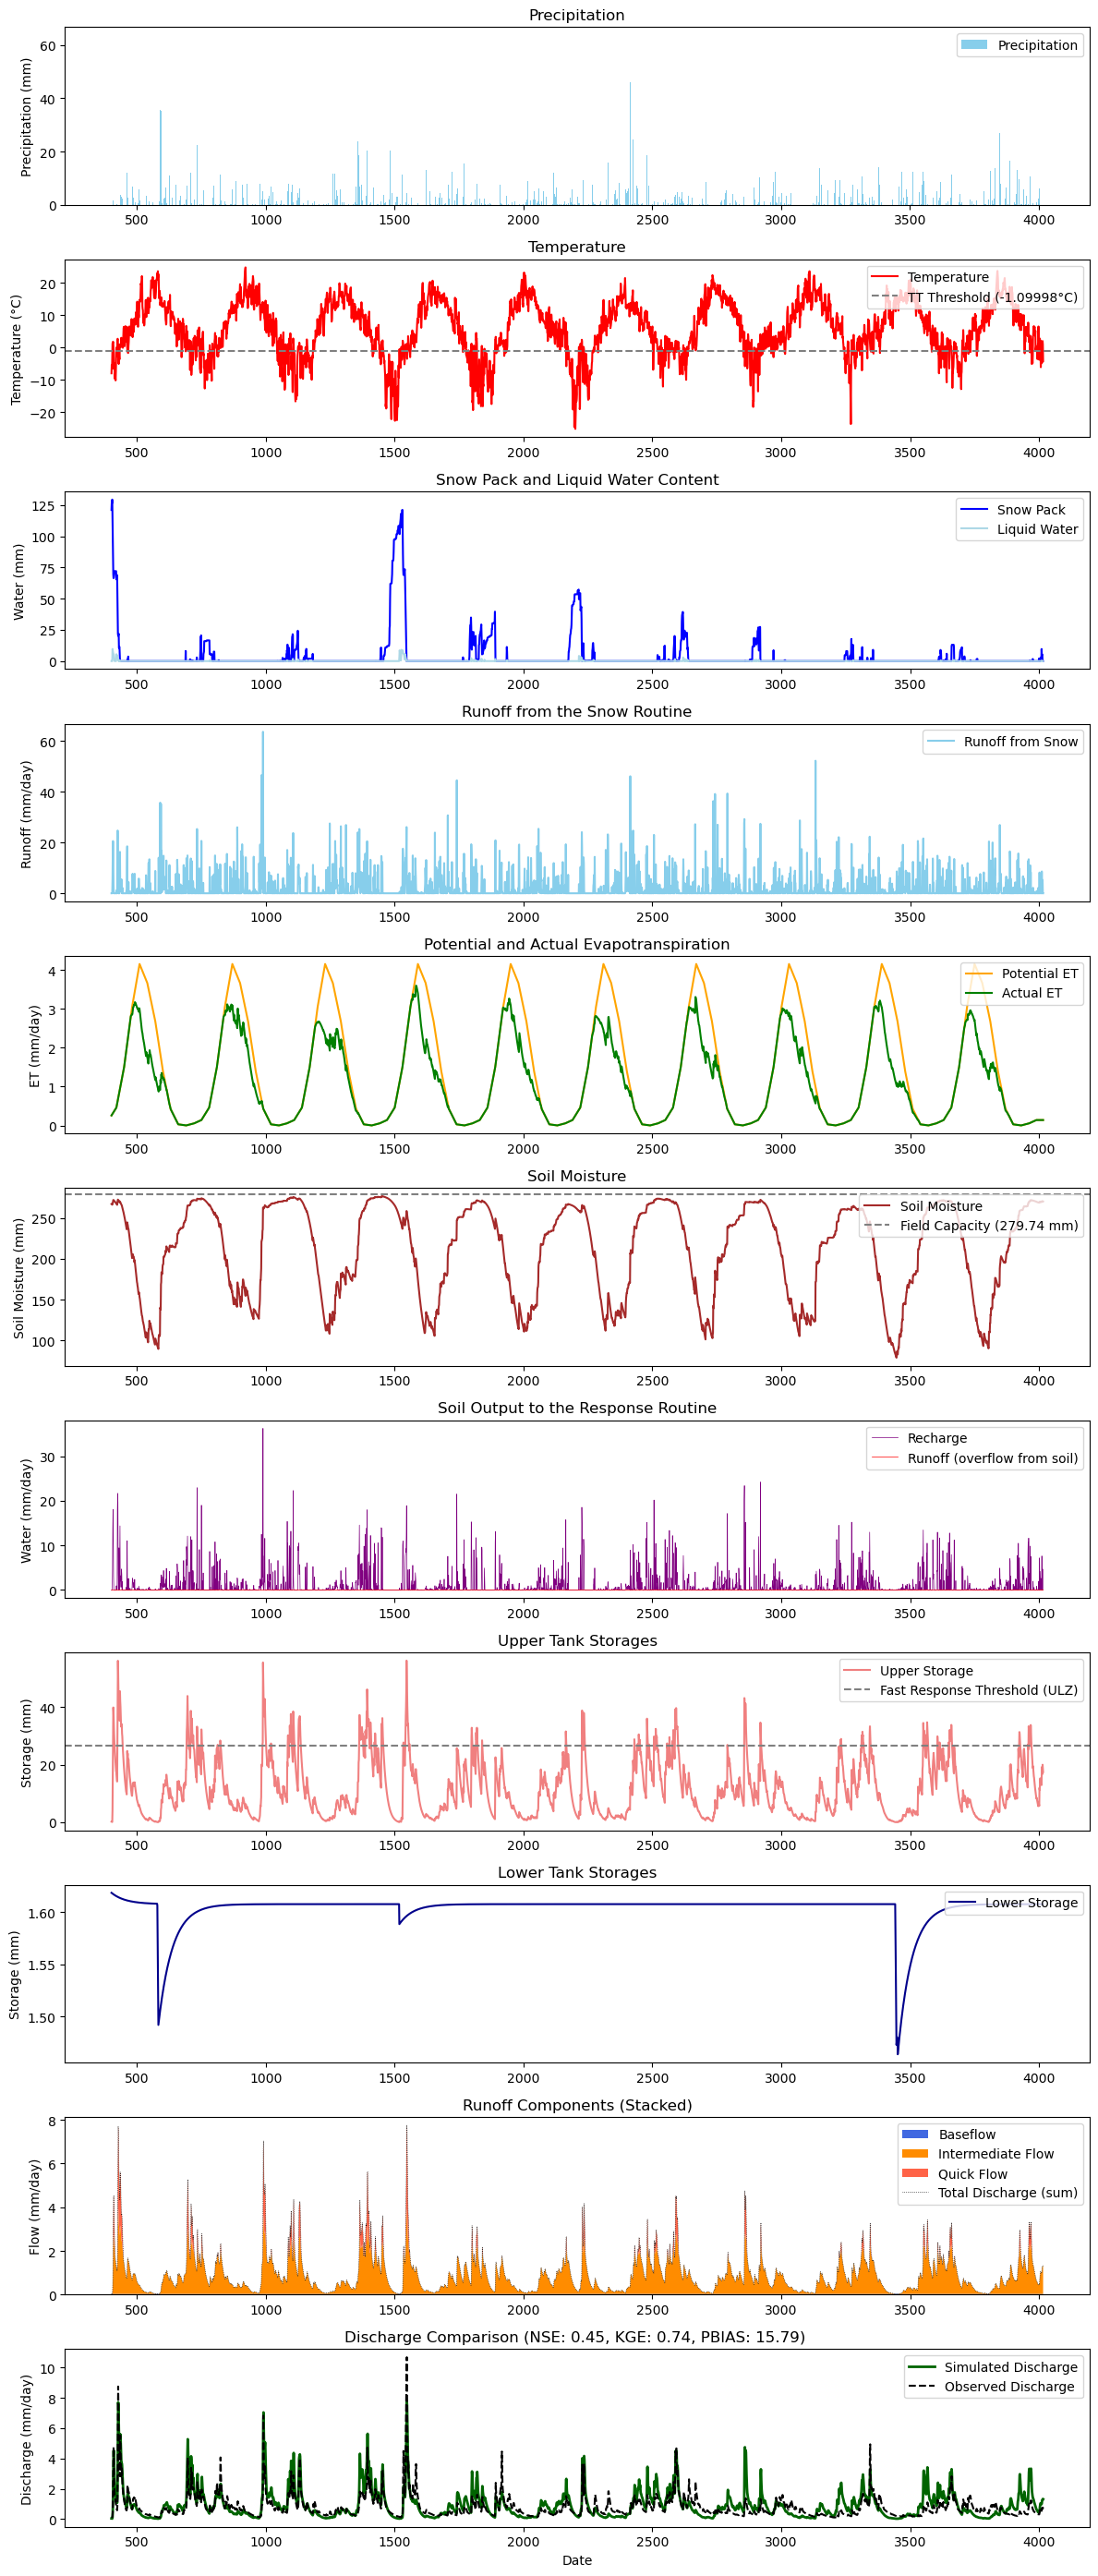

In [30]:
# 6. Visualize results
model_calibration.plot_results(output_file=None)

#7. Save results to CSV (optional)
# model_calibration.save_results("./results/hbv_uncalibrated_results.csv")

# Save the model for later use
# model_calibration.save_model('./models/ubnb_uncalibrated')

### Calibrate the Model

Starting calibration using SLSQP method...
Optimizing RMSE with 14 parameters and 500000000 iterations
Starting model run for 4017 time steps...
Applying MAXBAS routing with n=3 time steps
Model run completed successfully!
No warmup_end specified. Excluding first 401 timesteps (10% of data) as warmup period.
Performance metrics calculated:
NSE: 0.453
KGE: 0.745
PBIAS: 15.8%
Correlation: 0.806
Starting model run for 4017 time steps...
Applying MAXBAS routing with n=3 time steps
Model run completed successfully!
No warmup_end specified. Excluding first 401 timesteps (10% of data) as warmup period.
Performance metrics calculated:
NSE: 0.453
KGE: 0.745
PBIAS: 15.8%
Correlation: 0.806
Starting model run for 4017 time steps...
Applying MAXBAS routing with n=3 time steps
Model run completed successfully!
No warmup_end specified. Excluding first 401 timesteps (10% of data) as warmup period.
Performance metrics calculated:
NSE: 0.453
KGE: 0.745
PBIAS: 15.8%
Correlation: 0.806
Starting model run

c:\Users\abdal\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Applying MAXBAS routing with n=3 time steps
Model run completed successfully!
No warmup_end specified. Excluding first 401 timesteps (10% of data) as warmup period.
Performance metrics calculated:
NSE: 0.591
KGE: 0.798
PBIAS: 3.2%
Correlation: 0.801
Starting model run for 4017 time steps...
Applying MAXBAS routing with n=3 time steps
Model run completed successfully!
No warmup_end specified. Excluding first 401 timesteps (10% of data) as warmup period.
Performance metrics calculated:
NSE: 0.591
KGE: 0.798
PBIAS: 3.2%
Correlation: 0.801
Starting model run for 4017 time steps...
Applying MAXBAS routing with n=3 time steps
Model run completed successfully!
No warmup_end specified. Excluding first 401 timesteps (10% of data) as warmup period.
Performance metrics calculated:
NSE: 0.591
KGE: 0.798
PBIAS: 3.2%
Correlation: 0.801
Starting model run for 4017 time steps...
Applying MAXBAS routing with n=3 time steps
Model run completed successfully!
No warmup_end specified. Excluding first 401 t

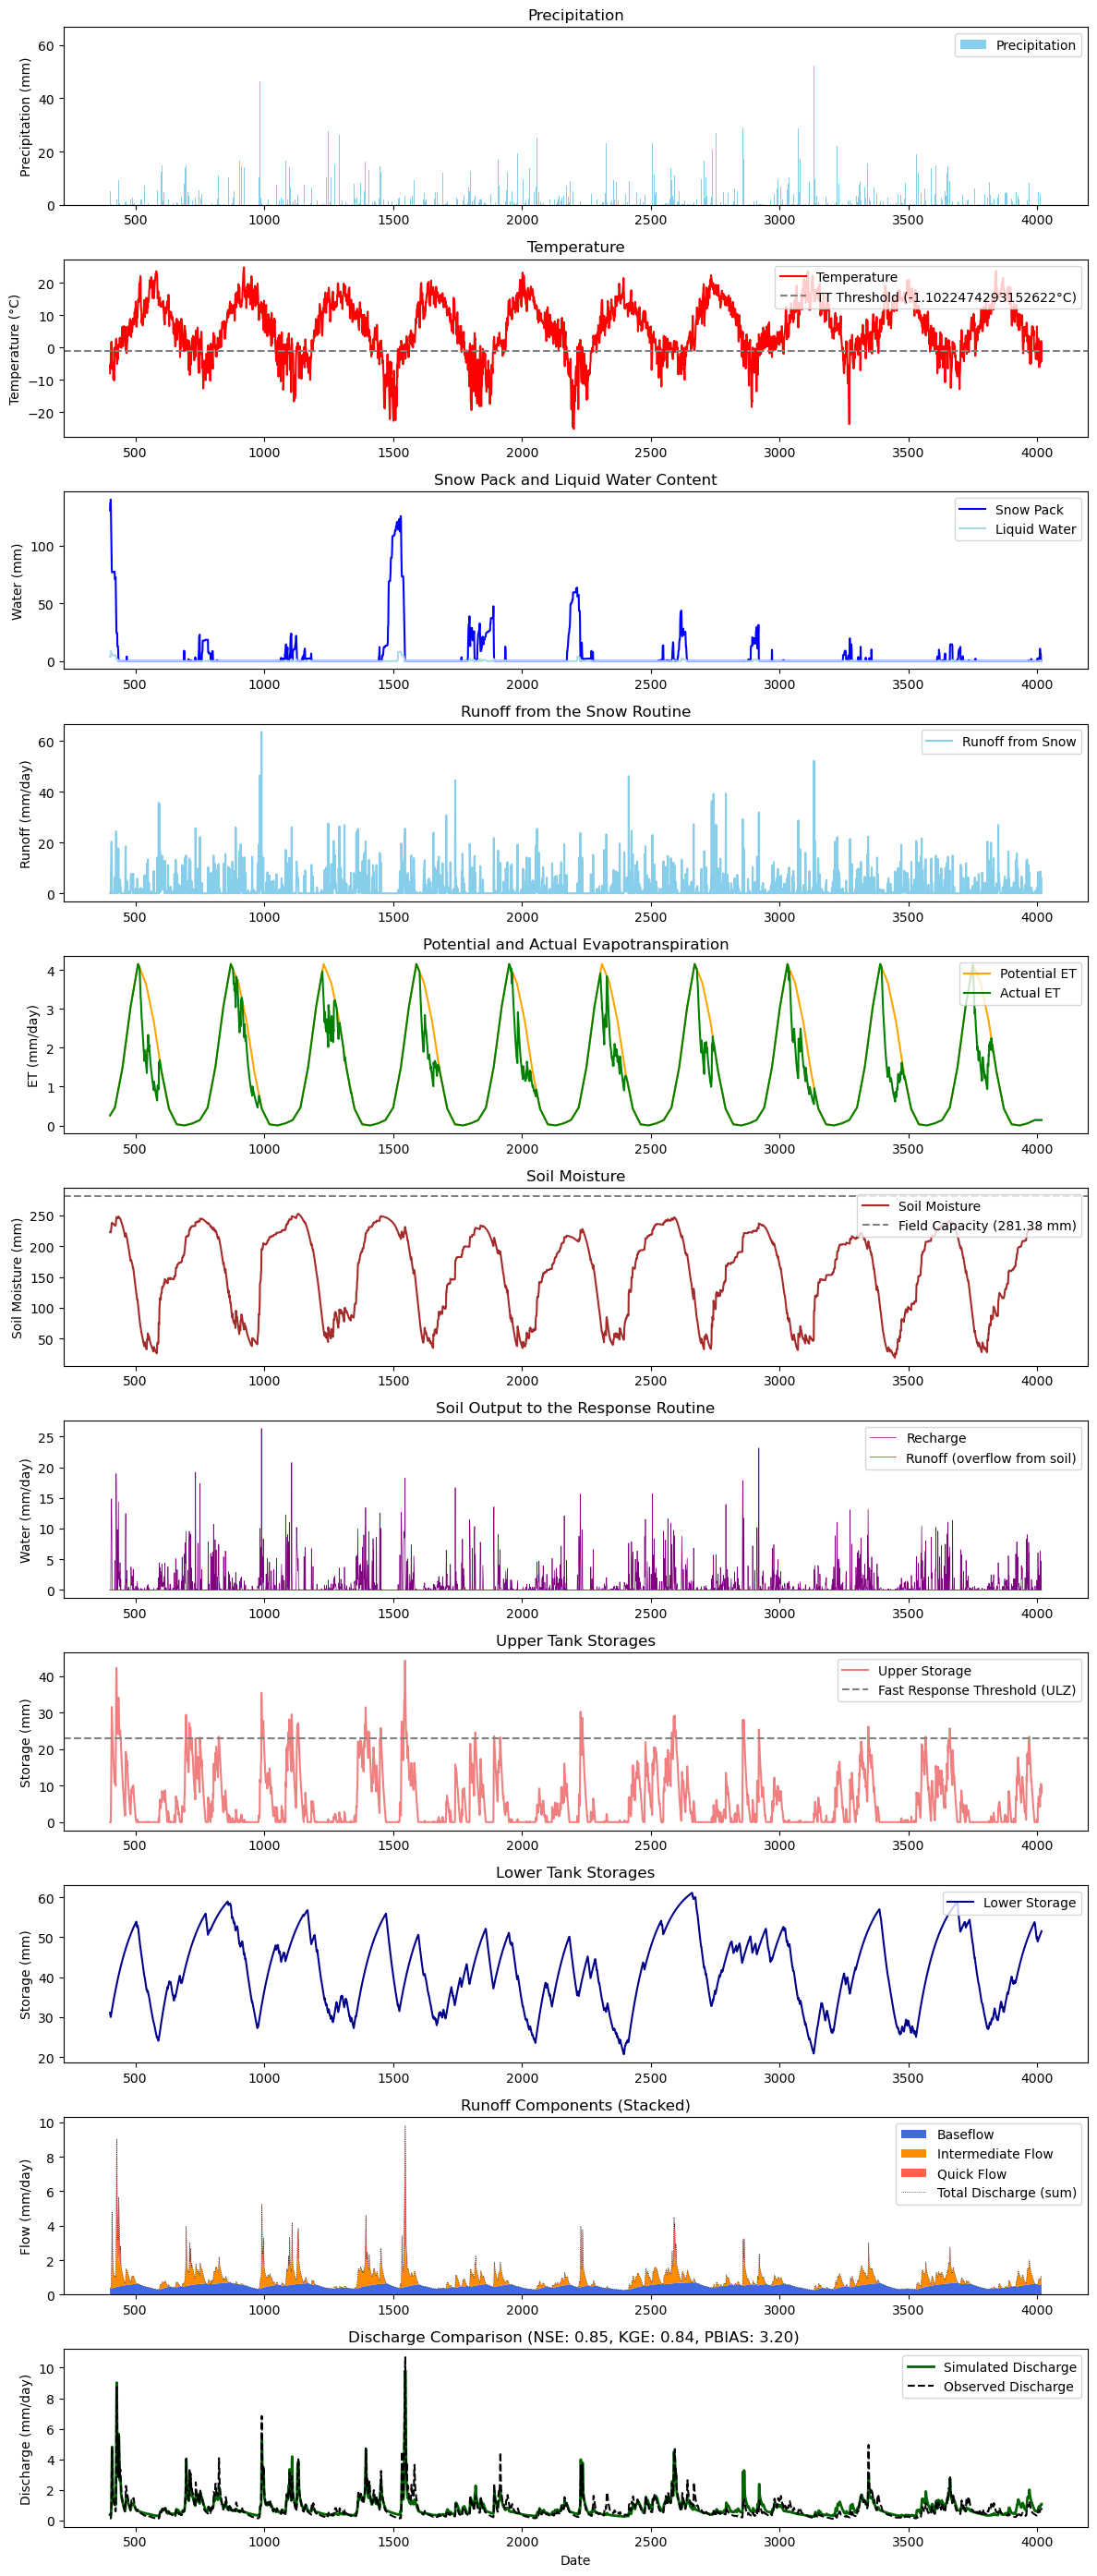

In [31]:
results = model_calibration.calibrate(
    method='SLSQP',     # Optimization algorithm——Options include 'SLSQP', 'L-BFGS-B', 'Nelder-Mead', etc.
    objective='RMSE',    # Objective function to optimize
    iterations=500000000,     # Maximum iterations
    verbose=True,       # Print progress
    plot_results=True   # Plot results after calibration
)

# The model now has calibrated parameters
# You can access them via model.params

# You can also access the calibration results
optimized_params = results['parameters']
performance = results['performance']
optimization_details = results['optimization_result']


In [32]:
model_calibration.params

{'response': {'K0': {'min': 0.01, 'max': 0.9, 'default': 0.2515131037389581},
  'K1': {'min': 0.005, 'max': 0.5, 'default': 0.048723208986896},
  'K2': {'min': 0.0005, 'max': 0.5, 'default': 0.01150289486474454},
  'UZL': {'min': 5.0, 'max': 50.0, 'default': 23.020167209007788},
  'PERC': {'min': 0.003, 'max': 25.0, 'default': 0.7571243141766634},
  'MAXBAS': {'min': 1, 'max': 10, 'default': 3.0}},
 'soil': {'FC': {'min': 50.0, 'max': 500.0, 'default': 281.3753147131527},
  'LP': {'min': 0.3, 'max': 1.0, 'default': 0.3},
  'BETA': {'min': 1.0, 'max': 35.0, 'default': 1.5373274158289914}},
 'snow': {'TT': {'min': -2.0, 'max': 2.0, 'default': -1.1022474293152622},
  'CFMAX': {'min': 1.0, 'max': 6.0, 'default': 6.0},
  'SFCF': {'min': 0.0, 'max': 1.5, 'default': 1.1517298265442781},
  'CFR': {'min': 0.0, 'max': 0.2, 'default': 0.0020338448046469146},
  'CWH': {'min': 0.0, 'max': 0.2, 'default': 0.06990255354640039}}}

In [ ]:
#model.plot_results(output_file='./figures/model_results_after_calibratoin.png')
#model.save_results(output_file='./results/results_after_calibration.csv')
#model_calibration.save_model(output_path='./models/model_calibrated')

Model saved to ./models/model_calibrated


### Testing the Model
```python
Now We shall test the Model for the Validation Period (start_date='1983-01-01', end_date='1991-01-01')


In [35]:
# 1. Initialize a model for the validation period 
model_validation = HBVModel()

# # Read the data from pandas df——with the validation dates instead
model_validation.load_data(data=data,
               date_column='Date',
               precip_column='P',
               temp_column='T',
               pet_column='PET',
               obs_q_column='Q',
               date_format='%Y%m%d',
               start_date='19880101', 
               warmup_end= None,         
               end_date= None,  )      # it is enough to use the start date 
                                       # the model will automatically continue till the end 

Detected 12 PET values (monthly means), expanding to daily values...
Time step detected: D
No warmup_end specified. Excluding first 10% of data when evaluating——as warmup period.
Loaded data with 1461 time steps, from 1988-01-01 00:00:00 to 1991-12-31 00:00:00


In [36]:
# set the calibrated parameters from the calibrated model
calibrated_parameters = model_calibration.params

# if you have the calibrated model saved you can load it and get its parameters 
# model_cal = HBVModel.load_model("./models/model_calibrated")
# calibrated_parameters = model_cal.params

model_validation.set_parameters(calibrated_parameters)

In [37]:
# Set initial conditions and run the model

model_validation.set_initial_conditions(
                                            snowpack=0,  #initial snowpack (mm)
                                            liquid_water=0,    # Initial liquid water in snow (mm)
                                            soil_moisture= 400,  # Initial soil moisture (mm)
                                            upper_storage=10,   # Initial upper zone storage (mm)
                                            lower_storage= 200, ) # Initial lower zone storage (mm)

results= model_validation.run(verbose=True)   # run the validation model

Initial conditions updated.
Starting model run for 1461 time steps...
Applying MAXBAS routing with n=3 time steps
Model run completed successfully!
No warmup_end specified. Excluding first 146 timesteps (10% of data) as warmup period.
Performance metrics calculated:
NSE: 0.771
KGE: 0.627
PBIAS: 2.6%
Correlation: 0.918


No warmup_end specified. Excluding first 146 timesteps (10% of data) as warmup period.


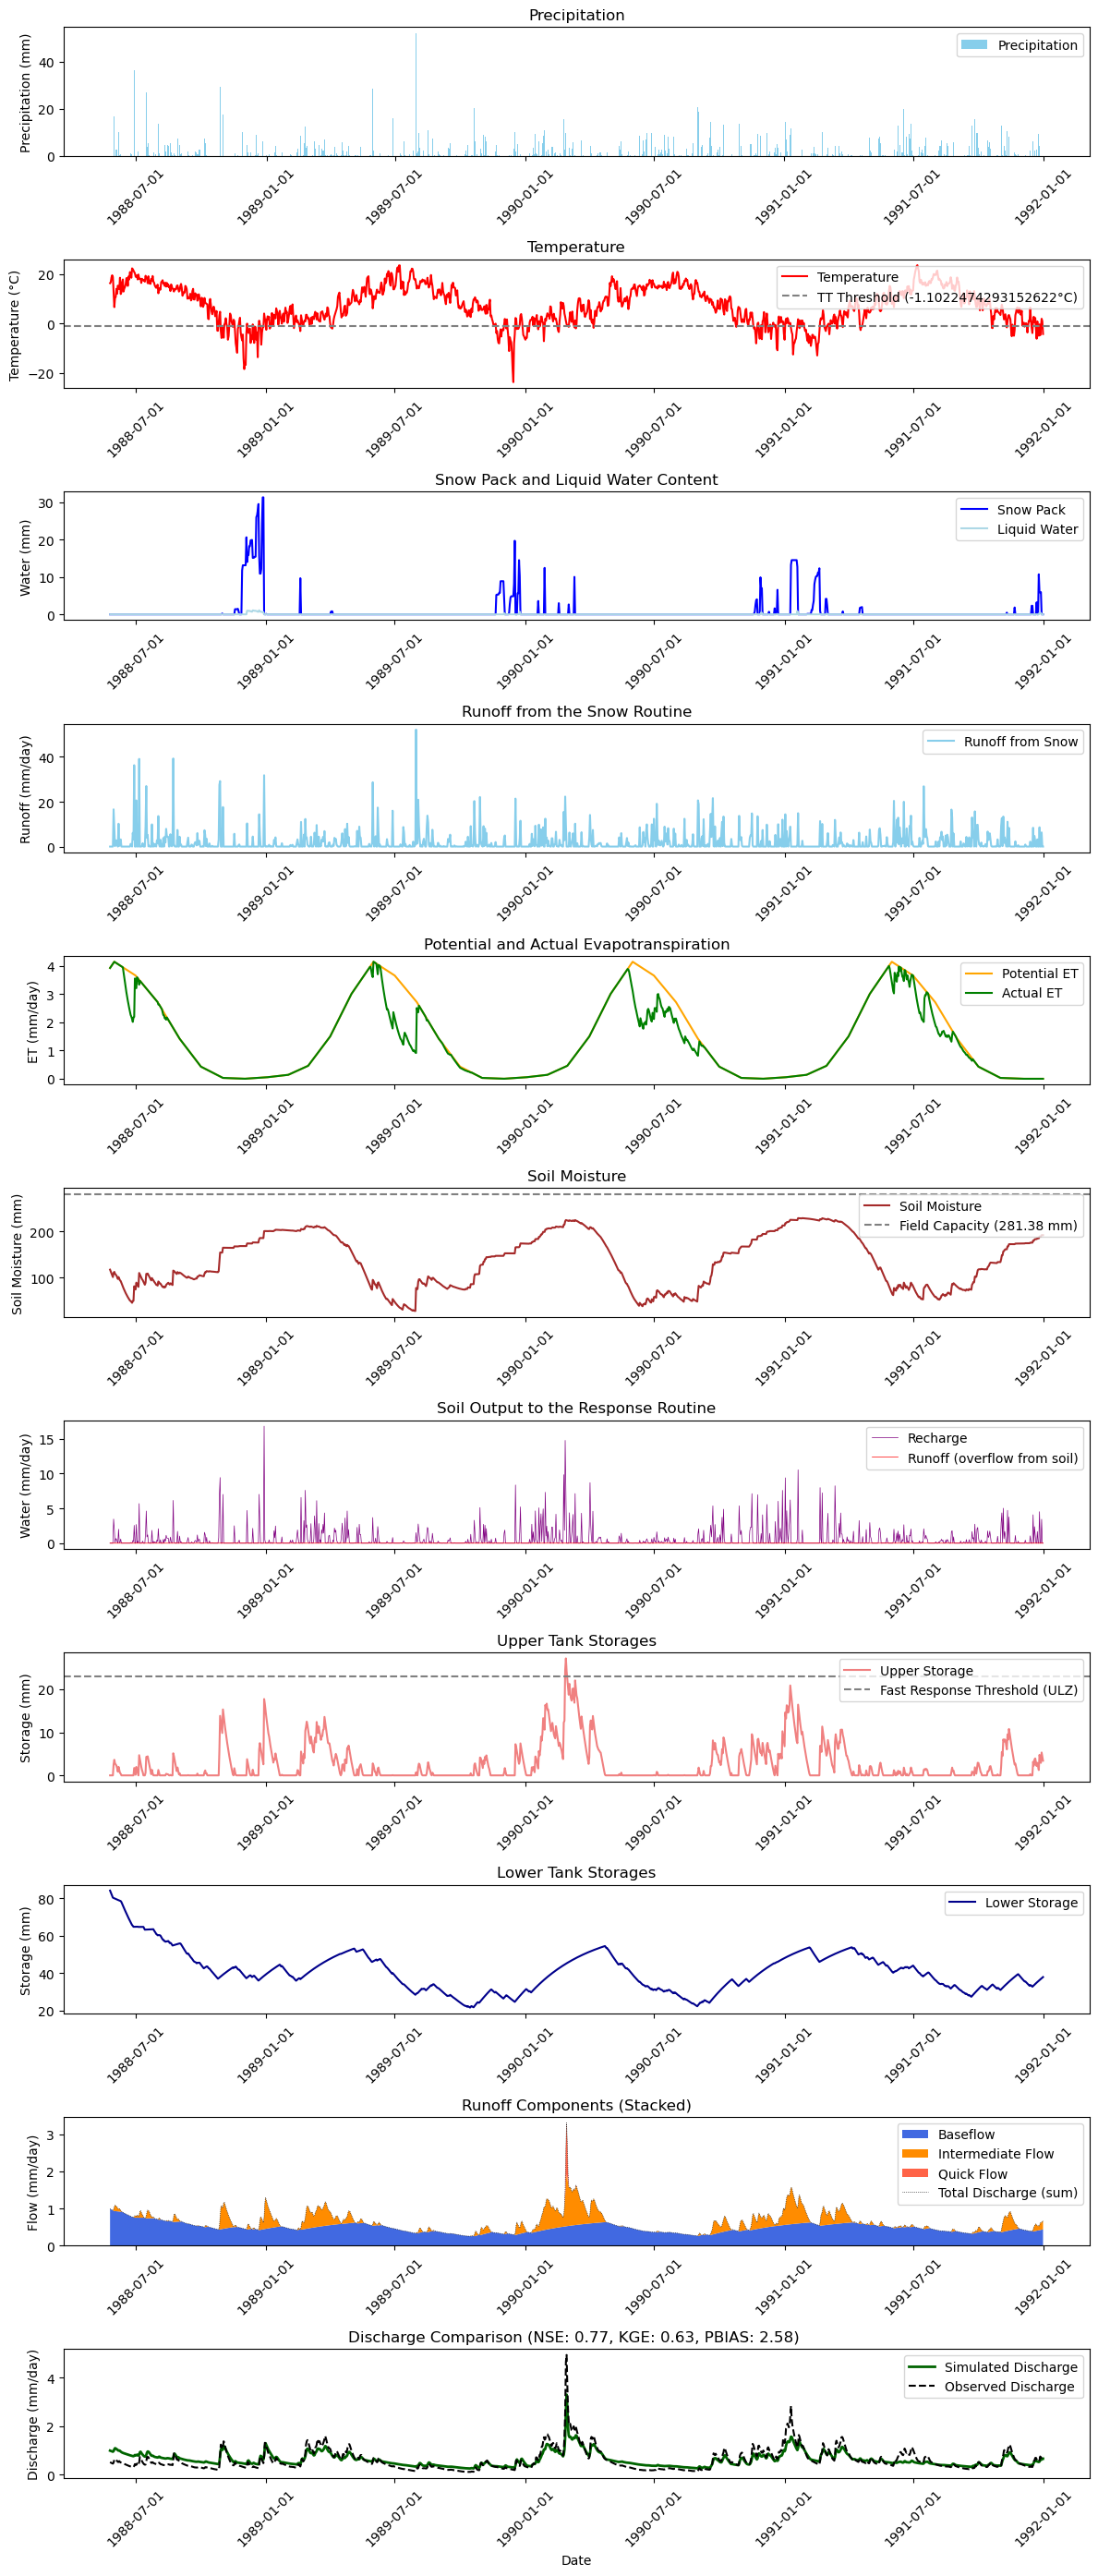

In [38]:
model_validation.plot_results(output_file=None)

In [13]:
model_validation.params

{'snow': {'TT': {'min': -2.0, 'max': 2.0, 'default': -0.9999995557474823},
  'CFMAX': {'min': 1.0, 'max': 6.0, 'default': 5.99521545816933},
  'SFCF': {'min': 0.0, 'max': 1.5, 'default': 1.0285375780226262},
  'CFR': {'min': 0.0, 'max': 0.2, 'default': 0.01828235336311188},
  'CWH': {'min': 0.0, 'max': 0.2, 'default': 0.06055321054070628}},
 'soil': {'FC': {'min': 50.0, 'max': 500.0, 'default': 279.75890634001956},
  'LP': {'min': 0.3, 'max': 1.0, 'default': 0.5321719398446558},
  'BETA': {'min': 1.0, 'max': 35.0, 'default': 1.9503941353046554}},
 'response': {'K0': {'min': 0.01, 'max': 0.9, 'default': 0.2687218612926844},
  'K1': {'min': 0.005, 'max': 0.5, 'default': 0.07619456869907822},
  'K2': {'min': 0.0005, 'max': 0.5, 'default': 0.024935378742070614},
  'UZL': {'min': 5.0, 'max': 50.0, 'default': 26.561036325102123},
  'PERC': {'min': 0.003, 'max': 25.0, 'default': 0.5496106463772685},
  'MAXBAS': {'min': 1, 'max': 10, 'default': 3.0}}}

### Evaluating the Parameters' Uncertainty 
```python
Now we do the uncertainity analyisis follwing Monte Carlo method. We sample uniformly from the parameters ranges n number of samples and we run the model n times with these samples. Best 10 runs are saved and used for estimating the uncertainity. 

Narrowed range snow_TT: -2.0000 to 2.0000
Narrowed range snow_CFMAX: 1.0000 to 6.0000
Narrowed range snow_SFCF: 0.0000 to 1.5000
Narrowed range snow_CFR: 0.0000 to 0.2000
Narrowed range snow_CWH: 0.0000 to 0.2000
Narrowed range soil_FC: 50.0000 to 500.0000
Narrowed range soil_LP: 0.3000 to 1.0000
Narrowed range soil_BETA: 1.0000 to 35.0000
Narrowed range response_K0: 0.0100 to 0.9000
Narrowed range response_K1: 0.0050 to 0.5000
Narrowed range response_K2: 0.0005 to 0.5000
Narrowed range response_UZL: 5.0000 to 50.0000
Narrowed range response_PERC: 0.0030 to 25.0000
Narrowed range response_MAXBAS: 1.0000 to 10.0000
Starting uncertainty analysis with 3000 runs...
Sampling 14 parameters uniformly across their ranges
Evaluating with KGE as the objective function


  0%|          | 0/3000 [00:00<?, ?it/s]

No warmup_end specified. Excluding first 146 timesteps (10% of data) from plots.


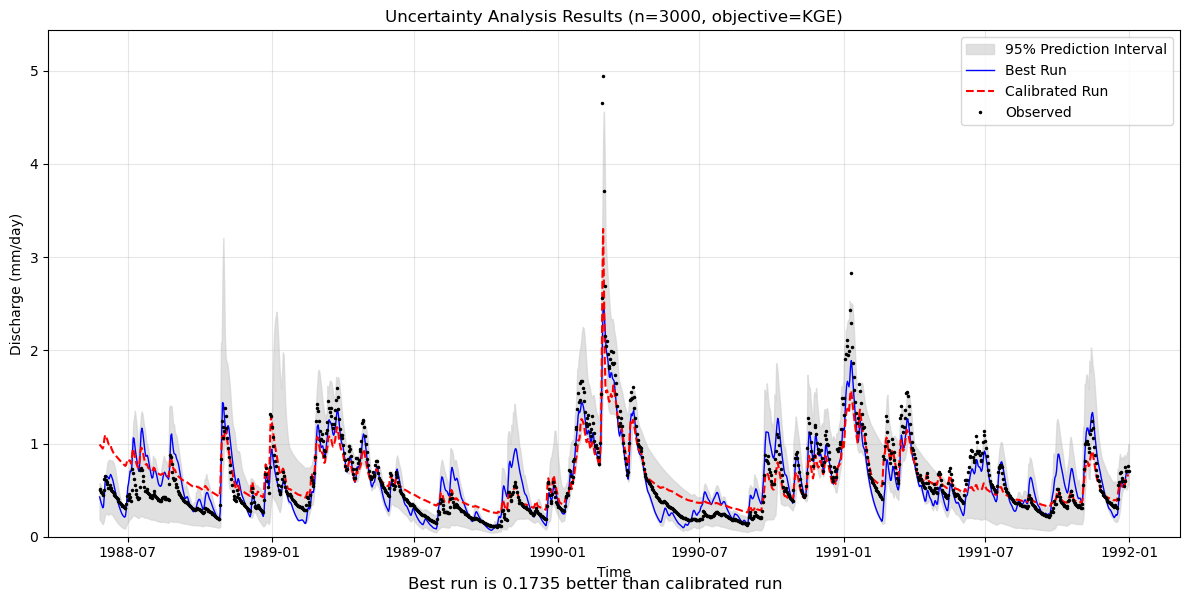

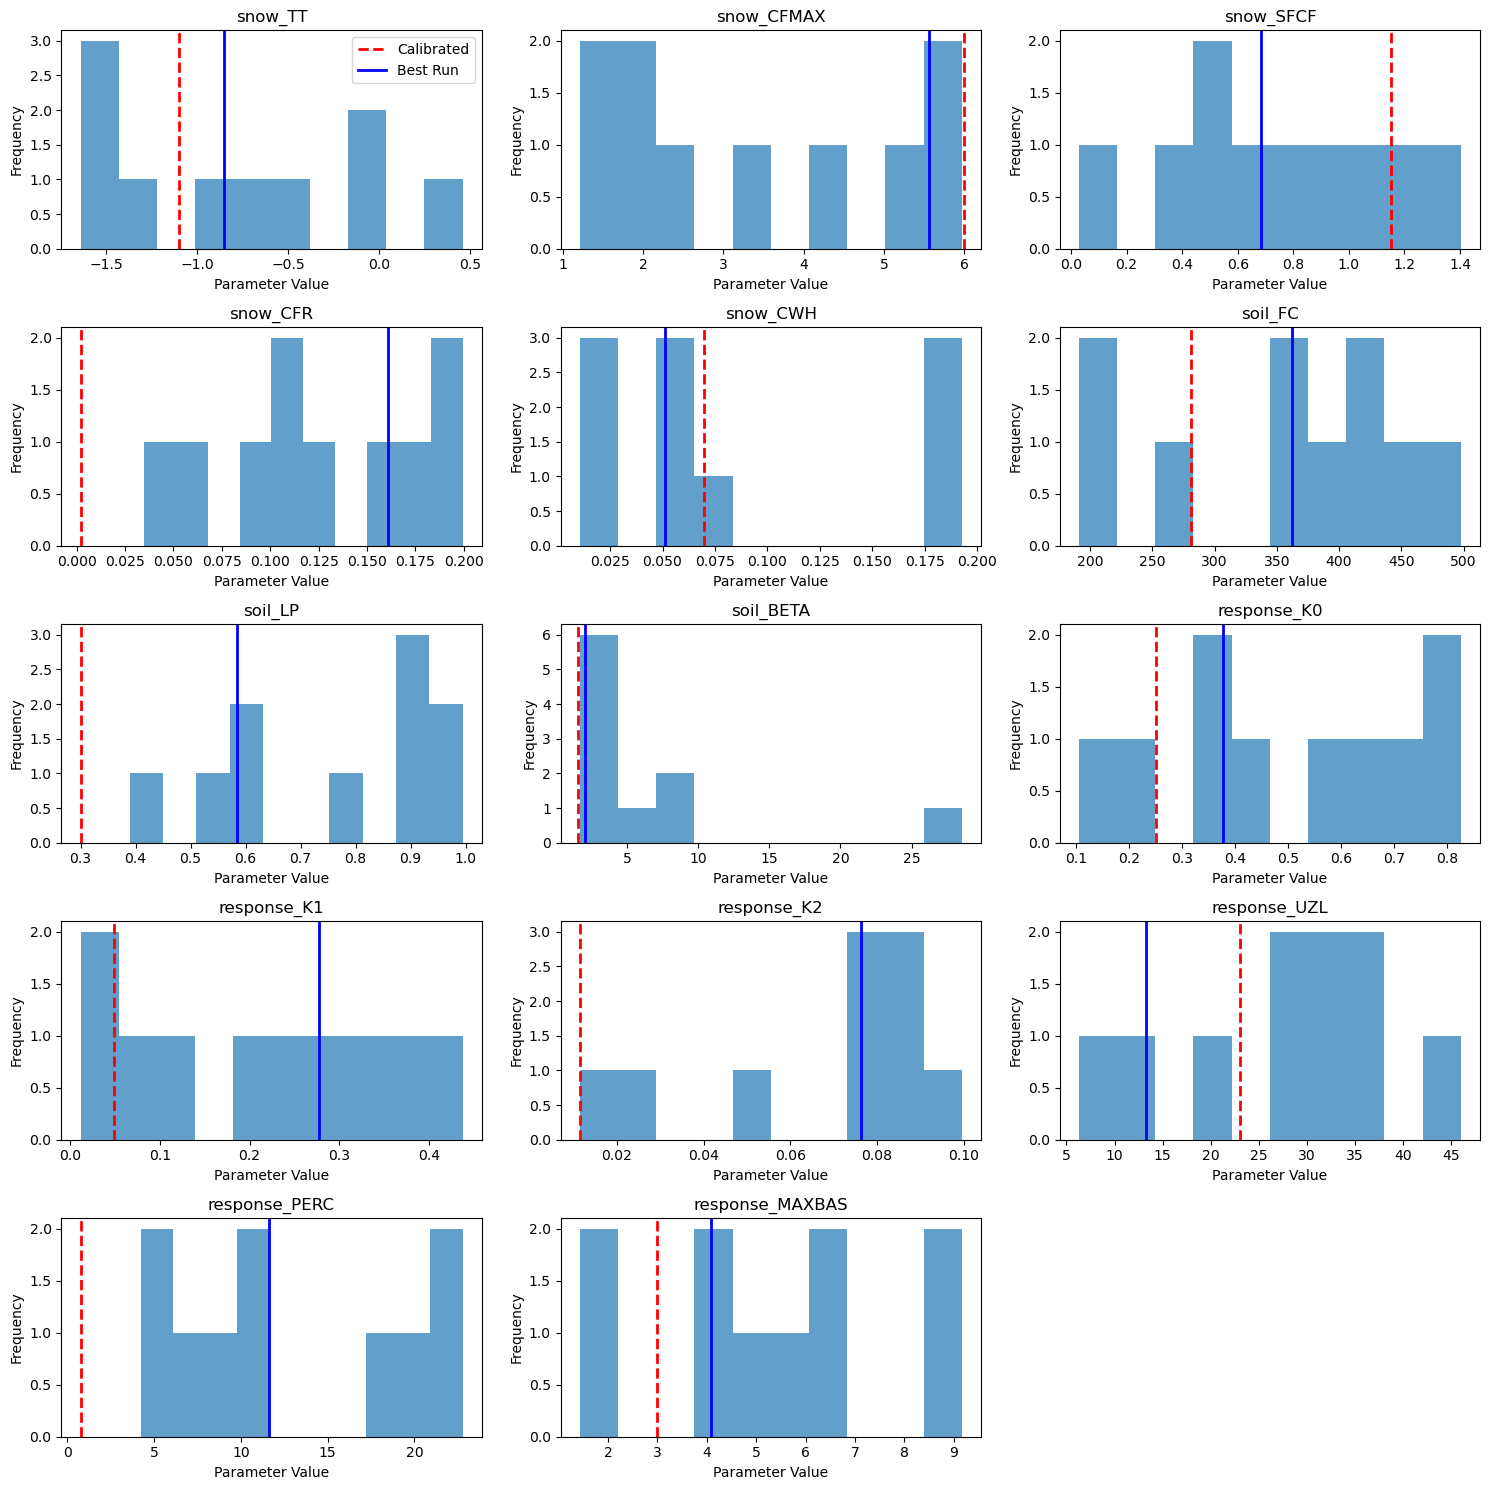


Uncertainty analysis completed in 41.06 seconds
Analyzed 3000 parameter sets

Top Performance Values:
  Run 1: KGE = 0.8006
  Run 2: KGE = 0.7843
  Run 3: KGE = 0.7838
  Run 4: KGE = 0.7702
  Run 5: KGE = 0.7561

Original (Calibrated) Performance: KGE = 0.6271
Best run is 0.1735 better than calibrated run


In [39]:
# Then run uncertainty analysis
uncertainty_results = model_validation.evaluate_uncertainty(
    n_runs=3000,            # Number of Monte Carlo runs
    objective='KGE',        # Performance metric to use for ranking the model runs
    save_best= 10,           # Number of best parameter sets to save
    plot_results=True,      # Generate visualization
    verbose=True,           # Print progress information
    seed=42 ,                # Optional random seed for reproducibility
    narrow_percent= 1,             
)

In [18]:
model_calibration.params

{'snow': {'TT': {'min': -2.0, 'max': 2.0, 'default': -1.0000158626201323},
  'CFMAX': {'min': 1.0, 'max': 6.0, 'default': 3.5273157095319236},
  'PCF': {'min': 0.65, 'max': 1.0, 'default': 0.6500000000003822},
  'SFCF': {'min': 0.0, 'max': 1.5, 'default': 1.4999999998070863},
  'CFR': {'min': 0.0, 'max': 0.2, 'default': 0.11858113171904767},
  'CWH': {'min': 0.0, 'max': 0.2, 'default': 0.19999998578981584}},
 'response': {'K0': {'min': 0.01, 'max': 0.9, 'default': 0.09098150132106998},
  'K1': {'min': 0.005, 'max': 0.5, 'default': 0.05490174618956252},
  'K2': {'min': 0.0005, 'max': 0.5, 'default': 0.0005622750513863762},
  'UZL': {'min': 5.0, 'max': 50.0, 'default': 27.91178855941013},
  'PERC': {'min': 0.03, 'max': 25.0, 'default': 0.7786497020117246}},
 'soil': {'FC': {'min': 50.0, 'max': 650.0, 'default': 449.7897763419051},
  'LP': {'min': 0.3, 'max': 1.0, 'default': 0.4273353353642021},
  'BETA': {'min': 1.0, 'max': 35.0, 'default': 2.5233409345231355}}}

In [19]:
custom_params_UBNB ={'response': {'K0': {'min': 0.001,
   'max': 0.1,
   'default': 0.017928309254250915},
  'K1': {'min': 5e-06, 'max': 5e-05, 'default': 5.0004427280349905e-06},
  'K2': {'min': 5e-07, 'max': 5e-06, 'default': 5e-06},
  'UZL': {'min': 1, 'max': 4, 'default': 1.494382401198882},
  'PERC': {'min': 1, 'max': 7, 'default': 4.287418116492705}},
 'soil': {'FC': {'min': 10, 'max': 30, 'default': 24.99995429108948},
  'LP': {'min': 0.3, 'max': 1.0, 'default': 0.7511074936130249},
  'BETA': {'min': 1.0, 'max': 35, 'default': 3.0001846960034175}},
 'snow': {'TT': {'min': -2.0, 'max': 2.0, 'default': 0.0},
  'CFMAX': {'min': 1.0, 'max': 6.0, 'default': 4.0},
  'PCF': {'min': 0.3, 'max': 1.0, 'default': 0.9273536670591036},
  'SFCF': {'min': 0, 'max': 1.5, 'default': 0.3},
  'CFR': {'min': 0.0, 'max': 0.2, 'default': 0.05},
  'CWH': {'min': 0.0, 'max': 0.2, 'default': 0.1}}}
custom_params_lookout = {
    'snow': {
        'TT': {'min': -2.0, 'max': 2.0, 'default': 0.0},      # Temperature threshold for snow/rain (°C)
        'CFMAX': {'min': 1.0, 'max': 6.0, 'default': 4},      # Degree-day factor (mm/°C/day)
        'PCF': {'min': 0.65, 'max': 1.0, 'default': 0.67},      # Precipitation correction factor (-)
        'SFCF': {'min': 0, 'max': 1.5, 'default': 0.3},     # Snowfall correction factor (-)
        'CFR': {'min': 0.0, 'max': 0.2, 'default': 0.05},     # Refreezing coefficient (-)
        'CWH': {'min': 0.0, 'max': 0.2, 'default': 0.1}       # Water holding capacity of snow (-)
    },
    'soil': {
        'FC': {'min': 50.0, 'max': 650, 'default': 450.0},  # Field capacity (mm)
        'LP': {'min': 0.3, 'max': 1.0, 'default': 0.75},      # Limit for potential evaporation (-)
        'BETA': {'min': 1.0, 'max': 35, 'default': 3.0}      # Shape coefficient (-)
    },
    'response': {
        'K0': {'min': 0.01, 'max': 0.9, 'default': 0.12},      # Quick flow recession coefficient (1/day)
        'K1': {'min': 0.05, 'max': 0.5, 'default': 0.05},     # Intermediate flow recession coefficient (1/day)
        'K2': {'min': 0.005, 'max': 0.5, 'default': 0.05},     # Baseflow recession coefficient (1/day)
        'UZL': {'min': 5.0, 'max': 50.0, 'default': 28.0},    # Upper zone threshold (mm)
        'PERC': {'min': 0.03, 'max': 25, 'default': 0.25}     # Percolation rate (mm/day)
    }
}

custom_params_HBV_land ={'response': {'K0': {'min': 0.01, 'max': 0.9, 'default': 0.11323336086000878},
  'K1': {'min': 0.005, 'max': 0.5, 'default': 0.0646675395143037},
  'K2': {'min': 0.0005, 'max': 0.5, 'default': 0.018321217741902936},
  'UZL': {'min': 5.0, 'max': 50.0, 'default': 26.61999369079226},
  'PERC': {'min': 0.03, 'max': 25, 'default': 0.03}},
 'soil': {'FC': {'min': 50.0, 'max': 650, 'default': 449.7368169438645},
  'LP': {'min': 0.3, 'max': 1.0, 'default': 0.7745757831402357},
  'BETA': {'min': 1.0, 'max': 35, 'default': 3.3155189242761236}},
 'snow': {'TT': {'min': -2.0, 'max': 2.0, 'default': -1.099975575374229},
  'CFMAX': {'min': 1.0, 'max': 6.0, 'default': 6.0},
  'PCF': {'min': 0.65, 'max': 1.0, 'default': 1.0},
  'SFCF': {'min': 0, 'max': 1.5, 'default': 1.0368534489917745},
  'CFR': {'min': 0.0, 'max': 0.2, 'default': 0.06867576949957854},
  'CWH': {'min': 0.0, 'max': 0.2, 'default': 0.08436634612318128}}}

